# XGBOOST Explanation

This notebook is focused on the explanation of the XGBoost model used to perform the `Task 4: classification`.

## Preparation of the model

In [1]:
from os import path
import pandas as pd
from preprocessing import get_train_test_data
from transformations import center_and_scale, drop_boolean
train_data, train_labels, test_data, test_labels, columns_to_keep = get_train_test_data()

train_data = drop_boolean(train_data)
test_data = drop_boolean(test_data)
full_dataset = pd.concat((train_data, test_data))

In [2]:
print(train_data.dtypes)

bmi                      float64
career_points            float64
career_duration(days)    float64
debut_year               float64
difficulty_score         float64
competitive_age            int64
climbing_efficiency      float64
startlist_quality          int64
avg_pos                  float64
dtype: object


In [3]:
import pandas as pd
result = pd.read_csv('xgboostresult.csv').sort_values(by='val_f1_score',ascending=False).head(10)
result

,gamma,lambda,learning_rate,max_depth,min_child_weight,n_estimators,scale_pos_weight,train_f1_score,val_f1_score
465,0.0,2,1.0,3,1,250,1,0.880052,0.880052
1761,0.2,2,1.0,3,1,250,1,0.880052,0.880052
1113,0.1,2,1.0,3,1,250,1,0.880052,0.880052
1545,0.2,1,1.0,3,1,250,1,0.879643,0.879643
51,0.0,0,1.0,3,3,250,1,0.879596,0.879596
699,0.1,0,1.0,3,3,250,1,0.879596,0.879596
1347,0.2,0,1.0,3,3,250,1,0.879596,0.879596
1122,0.1,2,1.0,3,2,250,1,0.879364,0.879364
1770,0.2,2,1.0,3,2,250,1,0.879364,0.879364
474,0.0,2,1.0,3,2,250,1,0.879364,0.879364


In [4]:
from xgboost import XGBClassifier

xgbc = XGBClassifier(
        gamma=0.0,
        reg_lambda=2,
        learning_rate=1.0,
        max_depth=3,
        min_child_weight=1,
        n_estimators=250,
        scale_pos_weight=1
)


xgbc.fit(train_data, train_labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1.0, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [5]:
from sklearn.metrics import classification_report

train_labels_model = xgbc.predict(train_data)
test_labels_model = xgbc.predict(test_data)
validation = classification_report(test_labels, test_labels_model, output_dict=True)

In [6]:
from sklearn.metrics import classification_report
def report_scores(test_label, test_pred):
    print(classification_report(test_label,
                            test_pred,
                            target_names=['0', '1']))

In [7]:
report_scores(test_labels, test_labels_model)

              precision    recall  f1-score   support

           0       0.87      0.96      0.91     30219
           1       0.43      0.16      0.23      5187

    accuracy                           0.85     35406
   macro avg       0.65      0.56      0.57     35406
weighted avg       0.81      0.85      0.81     35406



# Feature importance

In [8]:
perturbation_data = train_data
perturbation_labels = train_labels
perturbation_predictions = train_labels_model

explanation_data = test_data
explanation_labels = test_labels
explanation_predictions = test_labels_model

explanations = dict()

Here we we will analyse the feature importance of the Random Forest model that we have trained above. To do so, we will use the `shap` library. 
In particular, we will use the `shap.TreeExplainer` class to explain the predictions of the model because it is a tree-based model and it is the most appropriate class for this type of model.

In [9]:
import shap


interventional_explanation_algorithm = shap.TreeExplainer(
    model=xgbc,
    data=train_data,                       # perturb on a causal model induced on perturbation data
    feature_perturbation="interventional"  # use a causal model
)


distributional_explanation_algorithm = shap.TreeExplainer(
    model=xgbc,
    feature_perturbation="tree_path_dependent"  # condition on the distribution learned on the train data
)


In [10]:
interventional_explanations = interventional_explanation_algorithm(explanation_data)
distributional_explanations = distributional_explanation_algorithm(explanation_data)

explanations["shap_interventional"] = interventional_explanations.values
explanations["shap_distributional"] = distributional_explanations.values

100%|===================| 35272/35406 [01:21<00:00]        

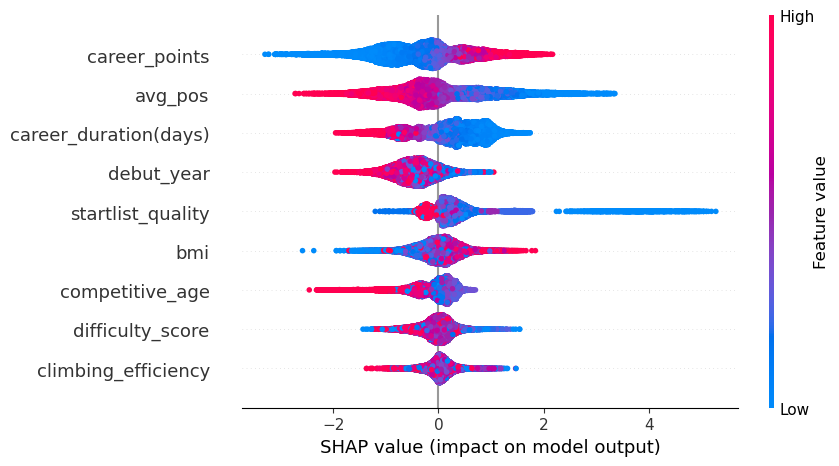

In [11]:
shap.plots.beeswarm(interventional_explanations)

The plot shows on the Y-axis the name of the features ordered by their impact on the model output, on the X-axis the SHAP values. The color of the points represents the value of the feature from low to high.
The plot is generated with `interventional` perturbation method that takes into account relationships in the data.

Looking at it we can say that:
- `career_points` has a strong positive impact on the model's output when the values are high and a negative impact when the values are low.
- `avg_pos` has mostly negative SHAP values when the feature value is high, suggesting that worse positions reduce the model's output.

- Longer `career_duration(days)` generally contribute positively to the model's predictions.

- `startlist_quality` shows a positive impact for low values
- high `competitive_age` has a mostly negative impact on the model's output.


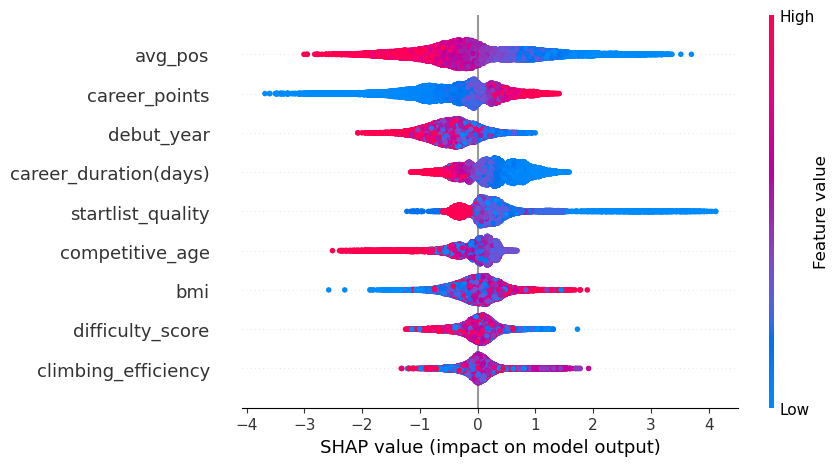

In [12]:
shap.plots.beeswarm(distributional_explanations)

This plot has been made by using the `tree_path_dependent` method where the feature impacts are reflected by the tree during training.
From the graph we can say that:
- `avg_pos` has the highest impact where higher values have a negative impact on the model's output.
- `career_points` has mostly a negative impact on the model's output when the values are low and a positive impact when the values are high.
- `debut year` has a negative impact for high values.
- `career_duration(days)` has a positive impact on the model's output mostly.

## Perturbation differences in Shap

Now we study the distribution of maximum differences per instance between the SHAP values obtained using interventional and tree_path_dependent perturbation methods.

In [13]:
import seaborn


explanation_differences = interventional_explanations.values - distributional_explanations.values
scaling_value = max((abs(interventional_explanations.values).max(), abs(distributional_explanations.values).max()))
maximum_differences_per_instance = explanation_differences.max(axis=1)
maximum_differences_per_feature = explanation_differences.max(axis=0)

<Axes: ylabel='Density'>

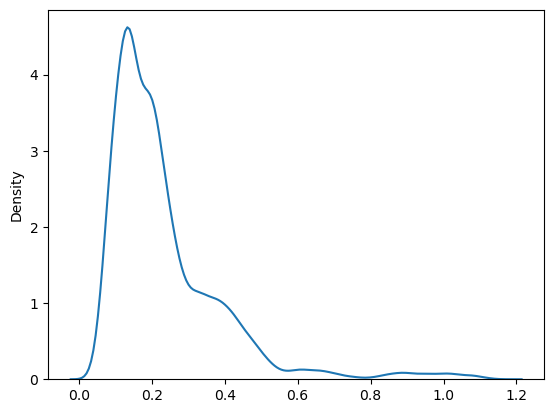

In [14]:
seaborn.kdeplot(maximum_differences_per_instance)

Here the X-axis represents the maximum difference between the SHAP values obtained using the two perturbation methods, while the Y-axis represents the density of the instances.

Most instances have a maximum SHAP differece around 0.2 indicating that the two methods are not very different in their predictions, the two explanation methods yield fairly similar results with small differences. The density drops after 0.6, indicating that large differences are rare, indicating that the two methos mostly align in their predictions..

Now we study which features have the highest differences in SHAP values between the two perturbation methods.

['bmi', 'career_points', 'career_duration(days)', 'debut_year', 'difficulty_score', 'competitive_age', 'climbing_efficiency', 'startlist_quality', 'avg_pos']


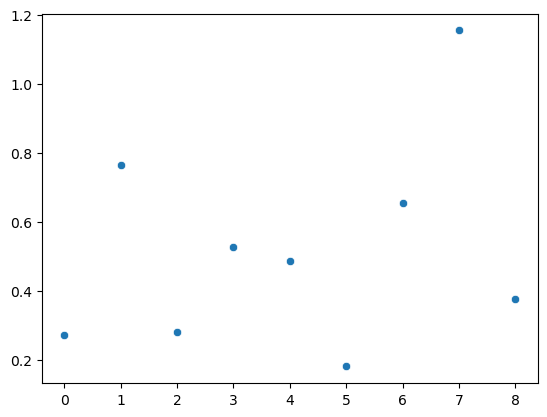

In [15]:
seaborn.scatterplot(maximum_differences_per_feature)
print(train_data.columns.tolist())

From the plot we can tell that `startlist_quality` has the highest maximum difference (around 1.2). This means that the two methods diverge significantly for this feature, other features like `bmi` and `competitive_age` are less affeccted by the chosen perturbation method and have in both methods impact similarly, other features like `debut_year` and `climbing_efficiency` fall in between, showing moderate differences.

## Explanation analysis

Are some features generally more impactful?

In [16]:
interventional_explanations_df = pd.DataFrame(interventional_explanations.values, columns=train_data.columns.tolist())
interventional_explanations_df.describe().drop("count", axis="rows")

,bmi,career_points,career_duration(days),debut_year,difficulty_score,competitive_age,climbing_efficiency,startlist_quality,avg_pos
mean,-0.000767,-0.295477,0.185234,-0.439581,-0.039891,-0.097195,0.032522,0.280525,0.035169
std,0.383450,0.821347,0.646042,0.377734,0.297327,0.401042,0.256796,0.638143,0.888397
min,-2.587815,-3.302707,-1.958738,-1.970669,-1.436844,-2.459067,-1.372127,-1.203620,-2.729122
25%,-0.220438,-0.883465,-0.263202,-0.691161,-0.191201,-0.309719,-0.087171,0.021558,-0.517112
50%,0.018610,-0.281921,0.294816,-0.432176,-0.012480,0.007998,0.034101,0.190241,-0.107036
75%,0.235831,0.242790,0.700476,-0.185266,0.144010,0.178999,0.155416,0.375736,0.597822
max,1.845072,2.172040,1.744827,1.053731,1.548039,0.704393,1.477617,5.278802,3.358486


From the table we can see that `career_points` has the highest absolute value of SHAP values, indicating that it is the most impactful feature in the model. This is followed by `startlist_quality`, `career_duration(days)`, `debut_year`.

For what instances are some features more/less impactful?

<Axes: xlabel='career_points', ylabel='Density'>

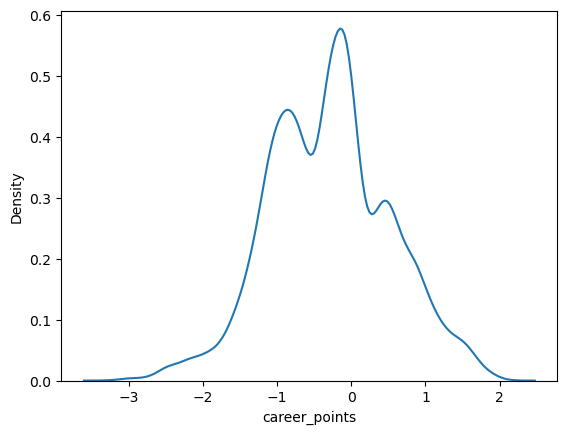

In [17]:
feature_of_interest = "career_points"
seaborn.kdeplot(interventional_explanations_df, x=feature_of_interest)

The plot above highlights how `career_points` contributes differently depending on the instance. 

In [18]:
number_quantiles = 40
quantiles = interventional_explanations_df["career_points"].quantile([q / number_quantiles for q in (range(number_quantiles))])
quantiles.diff()  # pick differences in quantiles

0.000         NaN
0.025    1.382344
0.050    0.349982
0.075    0.176845
0.100    0.115756
0.125    0.091392
0.150    0.069993
0.175    0.061999
0.200    0.059498
0.225    0.058307
0.250    0.053125
0.275    0.055805
0.300    0.054325
0.325    0.056649
0.350    0.061332
0.375    0.065893
0.400    0.072713
0.425    0.077078
0.450    0.059370
0.475    0.049777
0.500    0.048601
0.525    0.043247
0.550    0.042722
0.575    0.044252
0.600    0.040233
0.625    0.039119
0.650    0.041585
0.675    0.046778
0.700    0.054220
0.725    0.069754
0.750    0.102801
0.775    0.098194
0.800    0.083795
0.825    0.077599
0.850    0.088604
0.875    0.099267
0.900    0.117218
0.925    0.124452
0.950    0.168999
0.975    0.271877
Name: career_points, dtype: float64

<Axes: xlabel='career_duration(days)', ylabel='Density'>

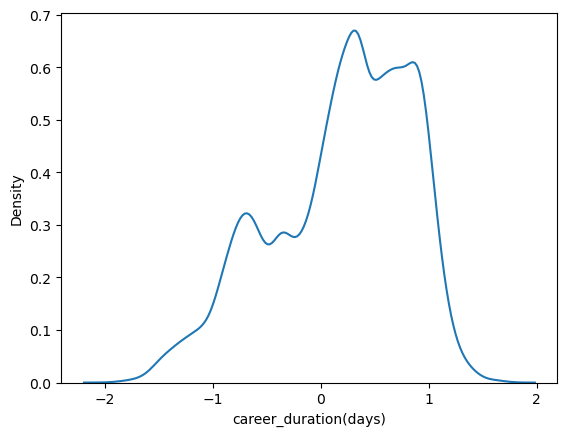

In [19]:
feature_of_interest = "career_duration(days)"
seaborn.kdeplot(interventional_explanations_df, x=feature_of_interest)

In [20]:
number_quantiles = 40
quantiles = interventional_explanations_df["career_duration(days)"].quantile([q / number_quantiles for q in (range(number_quantiles))])
quantiles.diff()  # pick differences in quantiles

0.000         NaN
0.025    0.741780
0.050    0.237691
0.075    0.117729
0.100    0.090963
0.125    0.072605
0.150    0.073121
0.175    0.084983
0.200    0.108165
0.225    0.081960
0.250    0.086540
0.275    0.093994
0.300    0.084577
0.325    0.072019
0.350    0.050624
0.375    0.051341
0.400    0.046124
0.425    0.040262
0.450    0.037642
0.475    0.038358
0.500    0.043075
0.525    0.033714
0.550    0.030232
0.575    0.032147
0.600    0.048016
0.625    0.052622
0.650    0.039509
0.675    0.039898
0.700    0.046227
0.725    0.042451
0.750    0.040843
0.775    0.038836
0.800    0.042583
0.825    0.047095
0.850    0.038252
0.875    0.035392
0.900    0.039036
0.925    0.043172
0.950    0.055107
0.975    0.087790
Name: career_duration(days), dtype: float64

<Axes: xlabel='debut_year', ylabel='Density'>

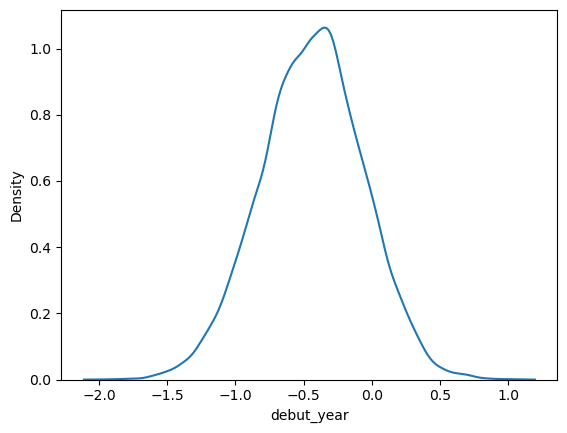

In [21]:
feature_of_interest = "debut_year"
seaborn.kdeplot(interventional_explanations_df, x=feature_of_interest)

In [22]:
number_quantiles = 40
quantiles = interventional_explanations_df["debut_year"].quantile([q / number_quantiles for q in (range(number_quantiles))])
quantiles.diff()  # pick differences in quantiles

0.000         NaN
0.025    0.778905
0.050    0.121367
0.075    0.078866
0.100    0.061910
0.125    0.050399
0.150    0.045253
0.175    0.041835
0.200    0.038260
0.225    0.032115
0.250    0.030596
0.275    0.028217
0.300    0.027026
0.325    0.028276
0.350    0.026132
0.375    0.024914
0.400    0.025642
0.425    0.026329
0.450    0.024924
0.475    0.023467
0.500    0.024057
0.525    0.024873
0.550    0.023285
0.575    0.023713
0.600    0.023123
0.625    0.022850
0.650    0.023626
0.675    0.023177
0.700    0.025566
0.725    0.027926
0.750    0.028772
0.775    0.031336
0.800    0.031392
0.825    0.036610
0.850    0.036959
0.875    0.041295
0.900    0.047407
0.925    0.056512
0.950    0.078693
0.975    0.109048
Name: debut_year, dtype: float64

<Axes: xlabel='startlist_quality', ylabel='Density'>

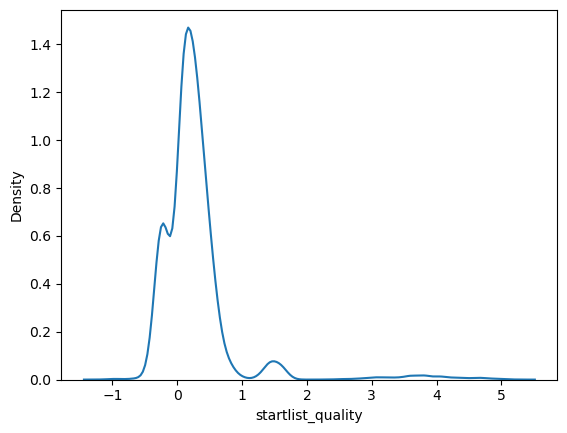

In [23]:
feature_of_interest = "startlist_quality"
seaborn.kdeplot(interventional_explanations_df, x=feature_of_interest)

In [24]:
number_quantiles = 40
quantiles = interventional_explanations_df["startlist_quality"].quantile([q / number_quantiles for q in (range(number_quantiles))])
quantiles.diff()  # pick differences in quantiles

0.000         NaN
0.025    0.865226
0.050    0.045158
0.075    0.031167
0.100    0.030597
0.125    0.031457
0.150    0.037741
0.175    0.046177
0.200    0.056543
0.225    0.049417
0.250    0.031694
0.275    0.024065
0.300    0.017932
0.325    0.015604
0.350    0.015350
0.375    0.014521
0.400    0.015041
0.425    0.015135
0.450    0.015842
0.475    0.017723
0.500    0.017470
0.525    0.017918
0.550    0.016271
0.575    0.015848
0.600    0.016644
0.625    0.017037
0.650    0.017866
0.675    0.018956
0.700    0.021548
0.725    0.020744
0.750    0.022664
0.775    0.023979
0.800    0.027565
0.825    0.030237
0.850    0.033472
0.875    0.041698
0.900    0.053302
0.925    0.086027
0.950    0.621583
0.975    0.360867
Name: startlist_quality, dtype: float64

The output shows a large initial differente from quantile 0 to 0.025 indicating that the SHAP values for `career_points` at the lower end of the distribution vary more significantly than higher quantiles.

This means that the feature `career_points` has a high impact on predictions for instances where its value is very low (cyclists with a very good performance in the past races).

In [25]:
import numpy

quantile_of_interest = quantiles[0.1]
interested_explanations = interventional_explanations_df[feature_of_interest].values

highly_impacted_instances = numpy.argwhere(interested_explanations <= quantile_of_interest).squeeze()
moderately_impacted_instances = numpy.array([i for i in range(interventional_explanations.shape[0]) if i not in highly_impacted_instances])

## What are the differences in instances for which the selected features is highly important?

In [26]:
full_dataset.iloc[highly_impacted_instances].describe().drop("count", axis="rows") - full_dataset.iloc[moderately_impacted_instances].describe().drop("count", axis="rows")

,bmi,career_points,career_duration(days),debut_year,difficulty_score,competitive_age,climbing_efficiency,startlist_quality,avg_pos
mean,-0.247877,-86.063800,-2.320928,-1.782185,-0.010448,-0.200325,-0.000998,20.359355,-1.971545
std,0.051332,1000.290971,13.099586,0.536182,0.003660,0.127910,-0.004503,8.371453,-2.433717
min,0.000000,0.000000,0.000000,0.000000,0.006642,1.000000,0.000000,26.000000,0.000000
25%,-0.351118,-475.000000,-6.000000,-1.000000,-0.004926,0.000000,0.000000,-2.000000,0.639890
50%,-0.014646,-1455.000000,-22.000000,-2.000000,-0.012093,0.000000,-0.000312,62.000000,-2.704841
75%,-0.073488,-1025.000000,-9.000000,0.000000,-0.026787,0.000000,-0.000521,93.000000,-5.210411
max,0.000000,-10597.221635,-59.000000,0.000000,-0.096675,0.000000,0.000000,0.000000,-9.582857


Now we analyze the highly impacted instances and moderately impacted instances for the feature `avg_pos`.

Now we analyze the highly impacted instances and moderately impacted instances for the feature `career_points`.

<Axes: xlabel='career_points', ylabel='Density'>

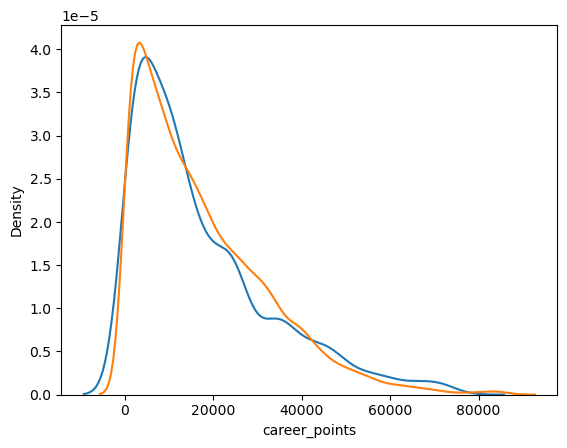

In [27]:
seaborn.kdeplot(full_dataset.iloc[highly_impacted_instances], x="career_points")
seaborn.kdeplot(full_dataset.iloc[moderately_impacted_instances], x="career_points")

<Axes: xlabel='career_duration(days)', ylabel='Density'>

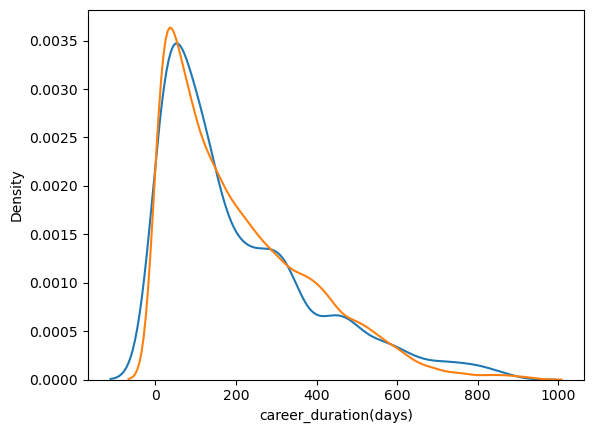

In [28]:
seaborn.kdeplot(full_dataset.iloc[highly_impacted_instances], x="career_duration(days)")
seaborn.kdeplot(full_dataset.iloc[moderately_impacted_instances], x="career_duration(days)")

<Axes: xlabel='debut_year', ylabel='Density'>

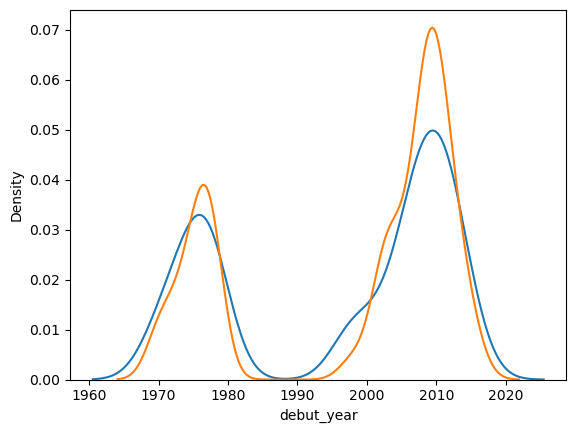

In [29]:
seaborn.kdeplot(full_dataset.iloc[highly_impacted_instances], x="debut_year")
seaborn.kdeplot(full_dataset.iloc[moderately_impacted_instances], x="debut_year")

<Axes: xlabel='startlist_quality', ylabel='Density'>

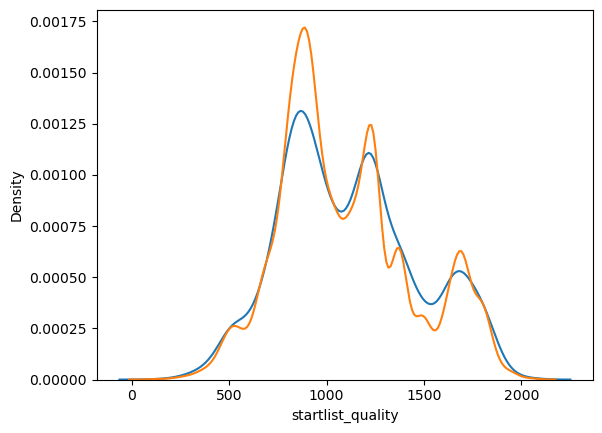

In [30]:
seaborn.kdeplot(full_dataset.iloc[highly_impacted_instances], x="startlist_quality")
seaborn.kdeplot(full_dataset.iloc[moderately_impacted_instances], x="startlist_quality")

## Validation
- `Sensitivity to perturbation`: does perturbation in the important features actually impact the model?
- `Iterative removal`: does removing important features worsen the model?
- `Iterative addition`: does adding important features improves the model?


In [31]:
pd.DataFrame(validation)

,0,1,accuracy,macro avg,weighted avg
precision,0.869878,0.431842,0.8461,0.650860,0.805706
recall,0.963864,0.160015,0.8461,0.561940,0.846100
f1-score,0.914462,0.233507,0.8461,0.573985,0.814702
support,30219.000000,5187.000000,0.8461,35406.000000,35406.000000


In [32]:
mean_absolute_importances = interventional_explanations_df.abs().mean()
features_by_importance = interventional_explanations_df.columns[mean_absolute_importances.argsort()].tolist()
features_by_importance

['climbing_efficiency',
 'difficulty_score',
 'competitive_age',
 'bmi',
 'startlist_quality',
 'debut_year',
 'career_duration(days)',
 'avg_pos',
 'career_points']

We start by constructing a set of corrupted datasets where noise at different magnitudes is inserted into the original dataset...

In [33]:
random_noise = numpy.random.rand(test_data.shape[0],)
noise_magnitudes = [eps / 10 for eps in range(1, 10)]

corruptions_by_feature_and_noise = dict()
for feature in features_by_importance:
    for noise_magnitude in noise_magnitudes:
        corruptions_by_feature_and_noise[(feature, noise_magnitude)] = test_data.copy()
        corruptions_by_feature_and_noise[(feature, noise_magnitude)][feature] = corruptions_by_feature_and_noise[(feature, noise_magnitude)][feature] + random_noise * noise_magnitude

... then validating the model on it.

In [34]:
validations_by_feature_and_noise = dict()
for (feature, noise), corruption in corruptions_by_feature_and_noise.items():
    validations_by_feature_and_noise[(feature, noise)] = classification_report(test_labels, xgbc.predict(corruption), output_dict=True)

In [35]:
metric = "f1-score"
corruption_validation = pd.DataFrame([
    (feature, noise_magnitude, validations_by_feature_and_noise[(feature, noise_magnitude)]["weighted avg"][metric], "shap")
    for feature, noise_magnitude in validations_by_feature_and_noise
    ],
    columns=["feature", "noise_magnitude", "performance", "algorithm"]
)
corruption_validation["difference"] = corruption_validation["performance"] - validation["weighted avg"][metric]
corruption_validation

,feature,noise_magnitude,performance,algorithm,difference
0,climbing_efficiency,0.1,0.809866,shap,-0.004836
1,climbing_efficiency,0.2,0.801765,shap,-0.012937
2,climbing_efficiency,0.3,0.806458,shap,-0.008244
3,climbing_efficiency,0.4,0.804950,shap,-0.009752
4,climbing_efficiency,0.5,0.803562,shap,-0.011140
...,...,...,...,...,...
76,career_points,0.5,0.814702,shap,0.000000
77,career_points,0.6,0.814702,shap,0.000000
78,career_points,0.7,0.814702,shap,0.000000
79,career_points,0.8,0.814702,shap,0.000000


In [36]:
corruption_validation.groupby("feature").describe()[["performance", "difference"]]

performance                                              \
                            count      mean           std       min       25%   
feature                                                                         
avg_pos                       9.0  0.814508  2.453699e-04  0.814100  0.814396   
bmi                           9.0  0.813192  5.457196e-04  0.812212  0.812943   
career_duration(days)         9.0  0.814702  1.177569e-16  0.814702  0.814702   
career_points                 9.0  0.814702  1.177569e-16  0.814702  0.814702   
climbing_efficiency           9.0  0.803697  2.929991e-03  0.801025  0.801698   
competitive_age               9.0  0.814702  1.177569e-16  0.814702  0.814702   
debut_year                    9.0  0.814702  1.177569e-16  0.814702  0.814702   
difficulty_score              9.0  0.814629  2.478477e-03  0.809928  0.813639   
startlist_quality             9.0  0.814702  1.177569e-16  0.814702  0.814702   

                                                    difference            \
                            50%       75%       max      count      mean   
feature                                                                    
avg_pos                0.814564  0.814681  0.814760        9.0 -0.000195   
bmi                    0.813340  0.813513  0.813885        9.0 -0.001510   
career_duration(days)  0.814702  0.814702  0.814702        9.0  0.000000   
career_points          0.814702  0.814702  0.814702        9.0  0.000000   
climbing_efficiency    0.802517  0.804950  0.809866        9.0 -0.011005   
competitive_age        0.814702  0.814702  0.814702        9.0  0.000000   
debut_year             0.814702  0.814702  0.814702        9.0  0.000000   
difficulty_score       0.815334  0.816395  0.817236        9.0 -0.000073   
startlist_quality      0.814702  0.814702  0.814702        9.0  0.000000   

                                                                         \
                            std       min       25%       50%       75%   
feature                                                                   
avg_pos                0.000245 -0.000602 -0.000306 -0.000138 -0.000021   
bmi                    0.000546 -0.002490 -0.001759 -0.001363 -0.001189   
career_duration(days)  0.000000  0.000000  0.000000  0.000000  0.000000   
career_points          0.000000  0.000000  0.000000  0.000000  0.000000   
climbing_efficiency    0.002930 -0.013677 -0.013005 -0.012185 -0.009752   
competitive_age        0.000000  0.000000  0.000000  0.000000  0.000000   
debut_year             0.000000  0.000000  0.000000  0.000000  0.000000   
difficulty_score       0.002478 -0.004774 -0.001063  0.000632  0.001693   
startlist_quality      0.000000  0.000000  0.000000  0.000000  0.000000   

                                 
                            max  
feature                          
avg_pos                0.000057  
bmi                   -0.000817  
career_duration(days)  0.000000  
career_points          0.000000  
climbing_efficiency   -0.004836  
competitive_age        0.000000  
debut_year             0.000000  
difficulty_score       0.002534  
startlist_quality      0.000000

In [37]:
corruption_validation.groupby("noise_magnitude").describe()[["performance", "difference"]]

performance                                                    \
                      count      mean       std       min       25%       50%   
noise_magnitude                                                                 
0.1                     9.0  0.814082  0.001652  0.809866  0.814653  0.814702   
0.2                     9.0  0.813324  0.004368  0.801765  0.814702  0.814702   
0.3                     9.0  0.813877  0.002865  0.806458  0.814702  0.814702   
0.4                     9.0  0.813746  0.003449  0.804950  0.814681  0.814702   
0.5                     9.0  0.813446  0.003804  0.803562  0.814564  0.814702   
0.6                     9.0  0.813269  0.004059  0.802517  0.814543  0.814702   
0.7                     9.0  0.812754  0.004477  0.801025  0.813639  0.814702   
0.8                     9.0  0.812573  0.004338  0.801430  0.812635  0.814702   
0.9                     9.0  0.812464  0.004334  0.801698  0.812943  0.814702   

                                    difference                                \
                      75%       max      count      mean       std       min   
noise_magnitude                                                                
0.1              0.814702  0.815266        9.0 -0.000620  0.001652 -0.004836   
0.2              0.814702  0.815996        9.0 -0.001378  0.004368 -0.012937   
0.3              0.814702  0.816421        9.0 -0.000825  0.002865 -0.008244   
0.4              0.814702  0.817236        9.0 -0.000956  0.003449 -0.009752   
0.5              0.814702  0.816395        9.0 -0.001256  0.003804 -0.011140   
0.6              0.814702  0.815334        9.0 -0.001433  0.004059 -0.012185   
0.7              0.814702  0.814702        9.0 -0.001949  0.004477 -0.013677   
0.8              0.814702  0.814702        9.0 -0.002129  0.004338 -0.013272   
0.9              0.814702  0.814702        9.0 -0.002238  0.004334 -0.013005   

                                               
                      25%  50%  75%       max  
noise_magnitude                                
0.1             -0.000049  0.0  0.0  0.000564  
0.2              0.000000  0.0  0.0  0.001294  
0.3              0.000000  0.0  0.0  0.001719  
0.4             -0.000021  0.0  0.0  0.002534  
0.5             -0.000138  0.0  0.0  0.001693  
0.6             -0.000159  0.0  0.0  0.000632  
0.7             -0.001063  0.0  0.0  0.000000  
0.8             -0.002067  0.0  0.0  0.000000  
0.9             -0.001759  0.0  0.0  0.000000

## Rule explanation

In this part we concentrate on the explanation on the rule explanation of the XGBOOST Model. To do so, we use the `LORE(Local Rule-based Explanations)` algorithm which uses local explanations based on rules for the prediction of the model.

In [38]:
from xailib.explainers.lore_explainer import LoreTabularExplainer

explanation_algorithm = LoreTabularExplainer(xgbc)

configuration = {
    "neigh_type": "rndgen",
    "size": 1000,
    "ocr":0.1,
    "ngen": 100
}

lore_train_data = pd.concat((train_data, train_labels), axis="columns")
explanation_algorithm.fit(lore_train_data, "top_20", config=configuration)
explanation = explanation_algorithm.explain(train_data.iloc[0].values)


Now the `explanation` object contains the rules that the model uses to make predictions. We can now get the rules by running the `get_rules` method on the `explanation` object.

In [39]:
# extract the rule for the given instance
explanation.getRules()

{'premise': [{'att': 'climbing_efficiency',
   'op': '>',
   'thr': 0.0018515691626816988,
   'is_continuous': True},
  {'att': 'career_points', 'op': '<=', 'thr': 4732.5, 'is_continuous': True},
  {'att': 'startlist_quality', 'op': '>', 'thr': 889.0, 'is_continuous': True},
  {'att': 'difficulty_score',
   'op': '<=',
   'thr': 1.105716049671173,
   'is_continuous': True},
  {'att': 'debut_year', 'op': '>', 'thr': 1974.5, 'is_continuous': True}],
 'cons': 0,
 'class_name': 'top_20'}

Now we can use the method `getCounterfactualRules` to get the counterfactual rules for the prediction of the model. The counterfactual rules are the rules that need to be satisfied in order to change the prediction of the model. 

In [40]:
explanation.getCounterfactualRules()

[{'premise': [{'att': 'climbing_efficiency',
    'op': '>',
    'thr': 0.016290809959173203,
    'is_continuous': True},
   {'att': 'career_points', 'op': '<=', 'thr': 4732.5, 'is_continuous': True},
   {'att': 'startlist_quality',
    'op': '<=',
    'thr': 889.0,
    'is_continuous': True},
   {'att': 'startlist_quality',
    'op': '>',
    'thr': 632.0,
    'is_continuous': True},
   {'att': 'debut_year', 'op': '<=', 'thr': 1993.5, 'is_continuous': True},
   {'att': 'career_duration(days)',
    'op': '<=',
    'thr': 210.0,
    'is_continuous': True}],
  'cons': 1,
  'class_name': 'top_20'},
 {'premise': [{'att': 'climbing_efficiency',
    'op': '<=',
    'thr': 0.016290809959173203,
    'is_continuous': True},
   {'att': 'climbing_efficiency',
    'op': '>',
    'thr': 0.0018515691626816988,
    'is_continuous': True},
   {'att': 'career_points', 'op': '<=', 'thr': 4732.5, 'is_continuous': True},
   {'att': 'startlist_quality',
    'op': '<=',
    'thr': 889.0,
    'is_continuous':

In [41]:
explanation.plotRules()

In [42]:
explanation.expDict["fidelity"]

0.9758984514821972

This fidelity tell us that the local model agrees with the predctions of the global model 99.7% of the synthetic neighbors used to build the local explanation.

## Counterfactual explanations

Here we provide the counterfactual explanations for the XGBOOST model. Counterfactual explanations are the instances that need to be changed in order to change the prediction of the model. To do it we use the `dice_ml` library.

In [43]:
import dice_ml

# need to convert data to the Dice format
dice_train_dataset = train_data.copy()
dice_train_dataset["top_20"] = train_labels
dice_dataset = dice_ml.Data(
    dataframe=dice_train_dataset,
    outcome_name="top_20",
    continuous_features=dice_train_dataset.columns.tolist()[:-1]
)

dice_model = dice_ml.Model(
    model=xgbc,
    backend="sklearn",  # dice supports several frameworks, e.g., pytorch, tensorflow
)


In [44]:
# the Dice object interfaces the counterfactual search
explanation_algorithm = dice_ml.Dice(
    dice_dataset,
    dice_model,
    method="random"  # random search for counterfactuals
    # method="gradient"  # gradient ASCent
    # method="genetic"  # genetic algorithm for search
)

explanation = explanation_algorithm.generate_counterfactuals(
    dice_train_dataset.iloc[[10000]].drop("top_20", axis="columns"),
    total_CFs=10,  # number of counterfactuals to generate
)

100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


We print the counterfactual explanations generated by DiCE for a specific query instance.

In [45]:
explanation.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 0)


,bmi,career_points,career_duration(days),debut_year,difficulty_score,competitive_age,climbing_efficiency,startlist_quality,avg_pos,top_20
0,20.528921,4380.0,51.0,1977.0,1.318487,25,0.018229,1241,49.039215,0



Diverse Counterfactual set (new outcome: 1)


,bmi,career_points,career_duration(days),debut_year,difficulty_score,competitive_age,climbing_efficiency,startlist_quality,avg_pos,top_20
0,-,-,-,-,-,-,-,116.0,-,1.0
1,-,-,-,-,-,-,0.147461006,-,-,1.0
2,-,-,-,-,-,-,1.352284536,203.0,-,1.0
3,-,32137.6,-,-,-,-,-,-,-,1.0
4,-,-,-,-,-,-,-,-,-,1.0
5,-,57346.1,-,-,-,-,-,-,-,1.0
6,-,73425.6,-,-,-,-,0.138703732,-,-,1.0
7,25.209127,-,-,-,-,-,-,-,-,1.0
8,-,-,-,-,2.6687011,-,-,-,-,1.0
9,-,-,-,-,-,-,-,-,-,1.0


In [46]:
explanation = explanation_algorithm.generate_counterfactuals(
    dice_train_dataset.iloc[[10000]].drop("top_20", axis="columns"),
    total_CFs=20,  # number of counterfactuals to generate
    features_to_vary=["climbing_efficiency", "career_points", "startlist_quality", "difficulty_score", "debut_year"], 
    stopping_threshold = 0.2
)

100%|██████████| 1/1 [00:54<00:00, 54.91s/it]


In [47]:
explanation.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 0)


,bmi,career_points,career_duration(days),debut_year,difficulty_score,competitive_age,climbing_efficiency,startlist_quality,avg_pos,top_20
0,20.528921,4380.0,51.0,1977.0,1.318487,25,0.018229,1241,49.039215,0



Diverse Counterfactual set (new outcome: 1)


,bmi,career_points,career_duration(days),debut_year,difficulty_score,competitive_age,climbing_efficiency,startlist_quality,avg_pos,top_20
0,-,-,-,-,0.7419067,-,-,407.0,-,1.0
1,-,15642.9,-,-,-,-,-,-,-,1.0
2,-,-,-,-,-,-,-,296.0,-,1.0
3,-,-,-,-,-,-,-,201.0,-,1.0
4,-,40788.4,-,-,2.5220058,-,-,-,-,1.0
5,-,-,-,-,-,-,-,443.0,-,1.0
6,-,-,-,-,1.3750842999994162,-,-,125.0,-,1.0
7,-,-,-,-,-,-,-,354.0,-,1.0
8,-,-,-,-,-,-,-,205.0,-,1.0
9,-,-,-,-,-,-,-,576.0,-,1.0


Now we generate the counterfactuals for the XGBOOST model. We take the first instance from `dice_train_dataset` to generate the counterfactuals. 

In [48]:
explanation = explanation_algorithm.generate_counterfactuals(
    dice_train_dataset.iloc[[10000]].drop("top_20", axis="columns"),
    total_CFs=20, # number of counterfactuals to generate
    features_to_vary = ["climbing_efficiency", "career_points", "startlist_quality", "difficulty_score", "debut_year"],  # more feature constraints
    stopping_threshold = 0.2
)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


In [49]:
counterfactuals = explanation.cf_examples_list[0].final_cfs_df
counterfactuals

,bmi,career_points,career_duration(days),debut_year,difficulty_score,competitive_age,climbing_efficiency,startlist_quality,avg_pos,top_20
0,20.528922,4380.0,51.0,1995.4,1.318487,25,0.018229,350,49.039216,1
1,20.528922,4380.0,51.0,1977.0,1.318487,25,0.090339,601,49.039216,1
2,20.528922,32276.7,51.0,1977.0,1.318487,25,0.018229,154,49.039216,1
3,20.528922,35413.9,51.0,1977.0,1.318487,25,0.170495,1241,49.039216,1
4,20.528922,4380.0,51.0,1977.0,1.318487,25,0.018229,554,49.039216,1
5,20.528922,41462.6,51.0,1977.0,1.318487,25,0.018229,418,49.039216,1
6,20.528922,4380.0,51.0,1977.0,1.318487,25,0.194627,148,49.039216,1
7,20.528922,4380.0,51.0,1977.0,1.318487,25,0.018229,320,49.039216,1
8,20.528922,4380.0,51.0,1977.0,1.318487,25,0.018229,1094,49.039216,1
9,20.528922,4380.0,51.0,1977.0,1.318487,25,0.018229,557,49.039216,1
